In [15]:
import os
import json
import pandas as pd
import yaml
import matplotlib.pyplot as plt

In [9]:
def read_log_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def load_model_mappings(mapping_file):
    with open(mapping_file, 'r') as f:
        return yaml.safe_load(f)['model_mappings']

def create_reverse_mapping(model_mappings):
    return {v: k for k, v in model_mappings.items()}

In [10]:
def merge_epoch_datasets(notable_models_file, large_scale_models_file):
    notable_models = pd.read_csv(notable_models_file)
    large_scale_models = pd.read_csv(large_scale_models_file)
    
    # Combine the datasets
    combined_models = pd.concat([notable_models, large_scale_models], ignore_index=True)
    
    # Remove duplicates if any, keeping the first occurrence
    combined_models = combined_models.drop_duplicates(subset='System', keep='first')
    
    return combined_models

In [11]:
def analyze_results(log_files_dir, model_mappings_file, notable_models_file, large_scale_models_file):
    model_mappings = load_model_mappings(model_mappings_file)
    epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)
    reverse_mappings = create_reverse_mapping(model_mappings)
    
    results = []
    
    for filename in os.listdir(log_files_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(log_files_dir, filename)
            log = read_log_file(file_path)
            
            if log['status'] == "success":
                model_name = log['eval']['model']
                
                # Extract data from logs
                accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                task_name = log['eval']['task']
                task_file = log['eval']['task_file']
                dataset_samples = log['eval']['dataset']['samples']
                completed_samples = log['results']['completed_samples']
                input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                start_time = log['stats']['started_at']
                end_time = log['stats']['completed_at']
                task_attribs = log['eval']['task_attribs']
                category = task_attribs.get('category')
                difficulty = task_attribs.get('difficulty')
                
                results.append({
                    'inspect_model_name': model_name,
                    'epoch_model_name': model_mappings.get(model_name, model_name),
                    'accuracy': accuracy,
                    'stderr': stderr,
                    'total_tokens': token_usage,
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'task': task_name,
                    'task_file': task_file,
                    'dataset_samples': dataset_samples,
                    'completed_samples': completed_samples,
                    'run_id': log['eval']['run_id'],
                    'created': log['eval']['created'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'category': category,
                    'difficulty': difficulty,
                    'filename': filename
                })
    
    df = pd.DataFrame(results)
    df = df.sort_values(['inspect_model_name', 'created'])
    
    # Merge with epoch data
    df = df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')
    
    # Add column for inspect model name that didn't match
    df['unmatched_inspect_model'] = df.apply(lambda row: row['inspect_model_name'] if pd.isna(row['System']) else None, axis=1)
    
    return df

In [12]:
# Usage
logs_dir = "../logs/gpqa-biology-complete/"
model_mappings_file = "../model_mappings.yaml"
notable_models_file = "../models/epoch-data/notable_ai_models.csv"
large_scale_models_file = "../models/epoch-data/large_scale_ai_models.csv"

results_df = analyze_results(logs_dir, model_mappings_file, notable_models_file, large_scale_models_file)

unmatched_models = results_df[results_df['unmatched_inspect_model'].notna()]['unmatched_inspect_model'].unique()
print("Unmatched models:", unmatched_models)

print(results_df)

Unmatched models: []
                     inspect_model_name   epoch_model_name  accuracy  \
0  anthropic/claude-3-5-sonnet-20240620  Claude 3.5 Sonnet  0.679487   
1      anthropic/claude-3-opus-20240229      Claude 3 Opus  0.551282   
2                 google/gemini-1.0-pro     Gemini 1.0 Pro  0.474359   
3                 google/gemini-1.5-pro     Gemini 1.5 Pro  0.512821   
4                  openai/gpt-3.5-turbo      GPT-3.5 Turbo  0.410256   
5                          openai/gpt-4              GPT-4  0.538462   
6                         openai/gpt-4o             GPT-4o  0.641026   

     stderr  total_tokens  input_tokens  output_tokens          task  \
0  0.053182         27803         27271            532  gpqa_biology   
1  0.056680         27786         27271            515  gpqa_biology   
2  0.056905         22969         22735            234  gpqa_biology   
3  0.056962         22969         22735            234  gpqa_biology   
4  0.056055         24445         24106   

In [20]:
def plot_accuracy_vs_publication_date(df):
    plt.figure(figsize=(12, 8))
    
    # Convert publication date to datetime
    df['Publication date'] = pd.to_datetime(df['Publication date'], errors='coerce')
    
    # Drop rows with NaN values
    plot_df = df.dropna(subset=['Publication date', 'accuracy'])
    
    # Sort by publication date
    plot_df = plot_df.sort_values('Publication date')
    
    # Create scatter plot
    plt.scatter(plot_df['Publication date'], plot_df['accuracy'], alpha=0.7)
    
    # Add labels for each point
    for _, row in plot_df.iterrows():
        plt.annotate(row['epoch_model_name'], 
                     (row['Publication date'], row['accuracy']),
                     xytext=(5, 5), 
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.8)
    
    plt.xlabel('Publication Date')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Publication Date')
    plt.grid(True, alpha=0.3)
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.savefig('accuracy_vs_publication_date.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_accuracy_vs_compute(df):
    plt.figure(figsize=(12, 8))
    
    # Convert compute cost to numeric, replacing any non-numeric values with NaN
    df['Training compute (FLOP)'] = pd.to_numeric(df['Training compute (FLOP)'], errors='coerce')
    
    # Drop rows with NaN values
    plot_df = df.dropna(subset=['Training compute (FLOP)', 'accuracy'])
    
    # Create scatter plot
    plt.scatter(plot_df['Training compute (FLOP)'], plot_df['accuracy'], alpha=0.7)
    
    # Add labels for each point
    for _, row in plot_df.iterrows():
        plt.annotate(row['epoch_model_name'], 
                     (row['Training compute (FLOP)'], row['accuracy']),
                     xytext=(5, 5), 
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.8)
    
    plt.xscale('log')  # Use log scale for x-axis due to large range of values
    plt.xlabel('Training compute (FLOP)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training Compute')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('accuracy_vs_compute.png', dpi=300, bbox_inches='tight')
    plt.show()

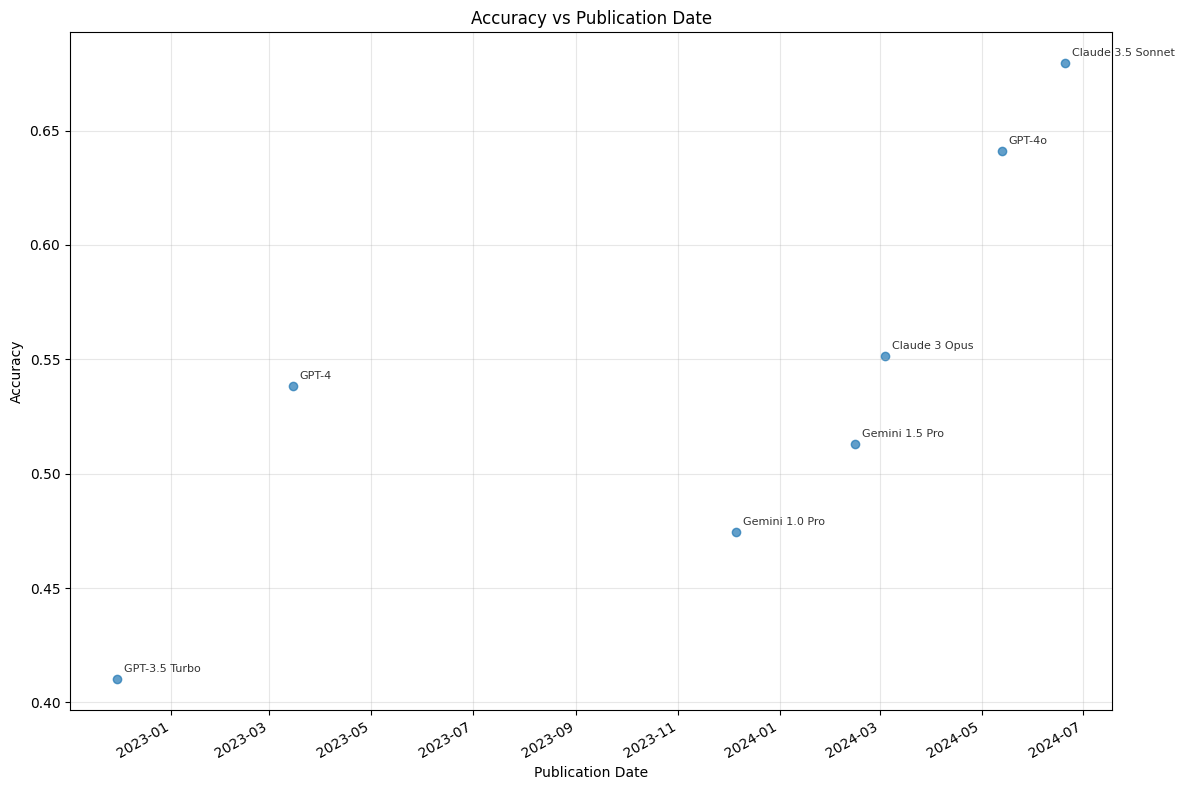

In [19]:
plot_accuracy_vs_publication_date(results_df)

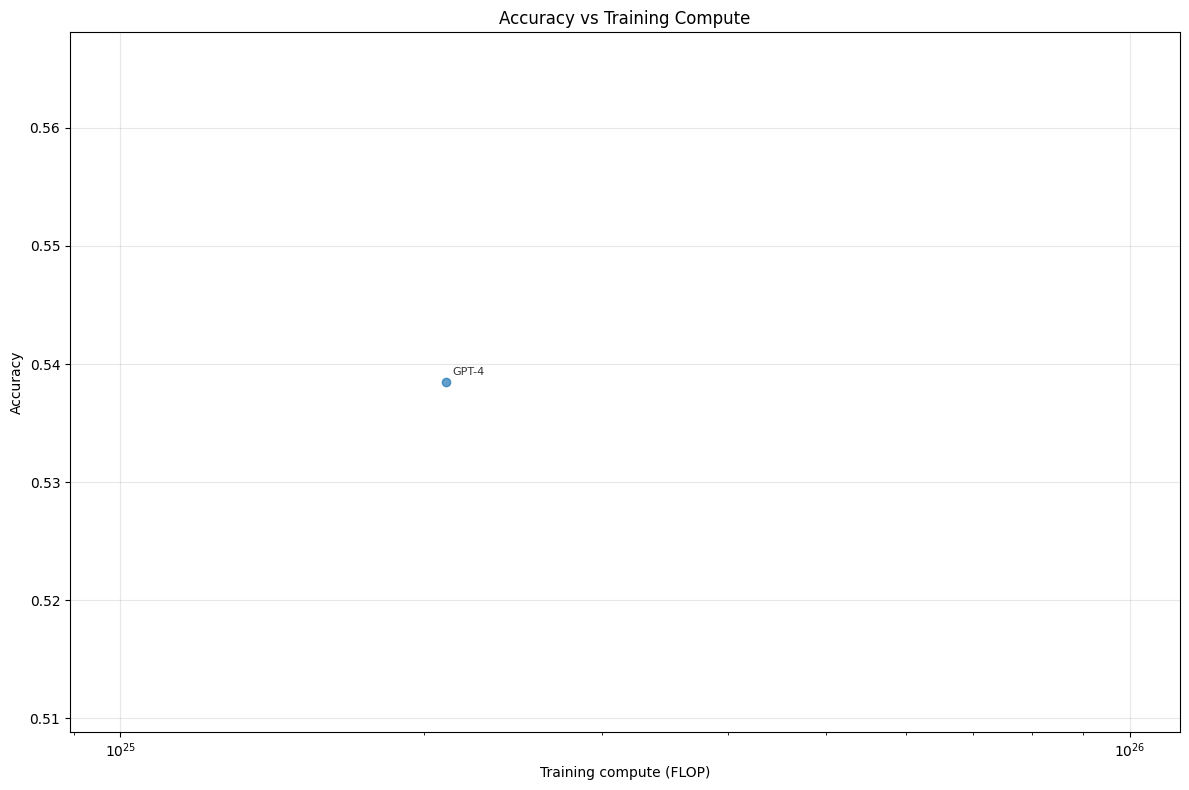

In [21]:
plot_accuracy_vs_compute(results_df)

In [ ]:
re